In [1]:
import torch
import torchvision
from torchvision import datasets,transforms, models
import os
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import Variable 
import time
%matplotlib inline
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import cv2
import torch.nn as nn

In [2]:
df = pd.read_excel('mci_conversion.xlsx')
df

,Unnamed: 0,RID,COLPROT,PTID,EXAMDATE,AGE,PTGENDER,CDRSB,MMSE,Hippocampus,WholeBrain,FDG,convert
0,3,51,1,099_S_0051,12/8/2005,66.5,0,1.0,27,6232.0,1098620.0,1.38960,0
1,4,54,1,099_S_0054,12/16/2005,81.0,1,2.5,27,4845.0,833179.0,0.93668,1
2,5,57,1,018_S_0057,1/6/2006,77.3,0,1.5,27,6767.0,1016500.0,1.06972,1
3,7,80,1,018_S_0080,1/13/2006,85.0,0,1.5,27,6482.0,925480.0,1.15745,0
4,9,101,1,007_S_0101,1/4/2006,73.6,0,0.5,27,6527.0,1081740.0,1.21602,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
462,537,4723,2,135_S_4723,6/5/2012,69.4,1,1.0,30,7759.0,1054570.0,1.46803,0
463,538,4813,2,053_S_4813,7/20/2012,67.6,0,1.0,29,8050.0,1015620.0,1.34695,0
464,539,4869,2,027_S_4869,9/10/2012,77.2,0,1.5,29,7689.0,1097580.0,1.39071,0
465,540,4896,2,126_S_4896,8/27/2012,68.1,0,1.0,30,7819.0,1230370.0,1.34987,0


In [3]:
transform = transforms.Compose([transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])])

In [4]:
pid = 'MCI_MPRAGE_2_016_S_1138a.jpg'

label = df.loc[df['PTID']== pid[13:23]]['AGE'].reset_index()
label['AGE'][0]

# c = df.loc[df['PTID']== pid[13:23]]['convert'].reset_index()
# c = c['convert'][0]
# c

67.4

In [5]:
# ADNI_002_S_0559_MR_MPR____N3__Scaled_2_Br_20081001115336170_S15922_I118679
class MyDataset(Dataset):
    def __init__(self, path, df, transform=transform):
        self.transform = transform
        self.images = os.listdir(path)
        self.labels = df
        self.path = path
 
    def __len__(self):
        return len(self.images)
 
    def __getitem__(self, index):
        img = cv2.imread(os.path.join(self.path,self.images[index]))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img2 = np.zeros_like(img)
        img2[:,:,0] = gray
        img2[:,:,1] = gray
        img2[:,:,2] = gray
        cv2.imwrite('./mci_rgb/'+self.images[index], img2)
        img = Image.open('./mci_rgb/'+self.images[index])
#         img = self.images[index, :, :, :]
#         img = img/1.0
#         img = torch.from_numpy(img).float()
#         label = self.labels[index]
        df_ = self.labels
        pid = self.images[index]
#         p_id = df_['PTID']
        sex = df_.loc[df_['PTID']== pid[0:10]]['PTGENDER'].reset_index()
        sex = sex['PTGENDER'][0]
        label = df_.loc[df_['PTID']== pid[0:10]]['AGE'].reset_index()
        label = label['AGE'][0]      
        conversion = df_.loc[df_['PTID']== pid[0:10]]['convert'].reset_index()
        convert = conversion['convert'][0]

        sample = {'id': pid[0:10], 'image': img, 'label': label, 'sex': sex, 'convert': convert, 'agegap': 0}
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample

In [6]:
path = './mci_jpg'
dataset = MyDataset(path=path,df=df)

In [7]:
print(len(dataset))
print(dataset[0]['image'].shape)

200
torch.Size([3, 224, 224])


In [8]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

False


In [9]:
model = models.vgg19()
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [10]:
for parma in model.parameters():
    parma.requires_grad = False

model.classifier = torch.nn.Sequential(torch.nn.Linear(25088, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 4096),
                                       torch.nn.ReLU(),
                                       torch.nn.Dropout(p=0.5),
                                       torch.nn.Linear(4096, 1))
    
if use_gpu:
    model = model.cuda()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [11]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [12]:
model.load_state_dict(torch.load('./best_model.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [13]:
from sklearn.metrics import mean_squared_error,r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

In [27]:
converts,retains=[],[]
idlist, agelist,sexlist,convertlist,agegaplist = [],[],[],[],[]
datalist=[]
for data in dataset:
    output = model(data['image'].unsqueeze(0)).detach().numpy()
    trueage = data['label']
    agegap = output - trueage
    if data['convert']==0:
        retains.extend(agegap)
    else:
        converts.extend(agegap)
        
    idlist.append(data['id'])
    agelist.append(data['label'])
    sexlist.append(data['sex'])
    convertlist.append(data['convert'])
    agegaplist.extend(agegap)
    
agegaplist

datalist = list(zip(idlist, agelist,sexlist,convertlist,agegaplist))

df1 = pd.DataFrame(data=datalist,
                      columns=['id', 'age','gender','convert','agegap'])

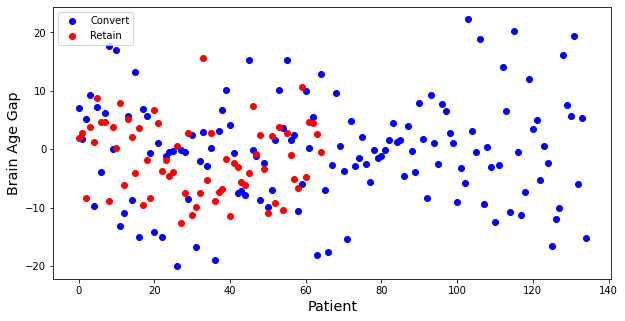

In [28]:
plt.figure(figsize=(10, 5))
 
num_c = range(0,len(converts))
num_r = range(0,len(retains))

plt.scatter(num_c, converts, color='blue', label="Convert")
plt.scatter(num_r, retains, color='red', label="Retain")

plt.ylabel("Brain Age Gap", fontsize='x-large')
plt.xlabel("Patient", fontsize='x-large')
plt.legend()

plt.show()


Brain Age Gap of Conversion
                0
count  135.000000
mean    -0.241104
std      8.847680
min    -20.050972
25%     -5.955704
50%     -0.135780
75%      5.296062
max     22.234005

Brain Age Gap of Retaining
               0
count  65.000000
mean   -1.529633
std     6.206624
min   -12.546524
25%    -6.630028
50%    -1.783401
75%     2.849533
max    15.617500


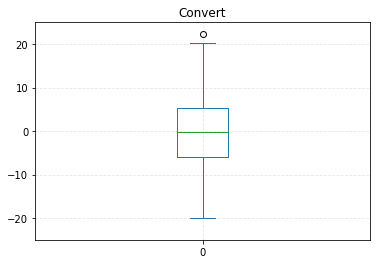

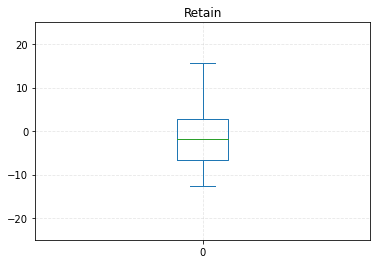

In [31]:
df_converts = pd.DataFrame(converts)

print('Brain Age Gap of Conversion')
print(df_converts.describe())
df_converts.plot.box(title="Convert")
plt.grid(linestyle="--", alpha=0.3)
plt.ylim(-25,25)
print()
df_retains = pd.DataFrame(retains)
print('Brain Age Gap of Retaining')
print(df_retains.describe())
df_retains.plot.box(title="Retain")
plt.grid(linestyle="--", alpha=0.3)
plt.ylim(-25,25)
plt.show()

In [33]:



df1.to_csv('mci_.csv', index=False)
df1


,id,age,gender,convert,agegap
0,023_S_1046,71.6,0,0,[1.8606339]
1,016_S_1138,67.4,0,1,[7.0517807]
2,023_S_0030,80.0,1,1,[1.7800751]
3,023_S_0376,70.5,0,0,[2.7118073]
4,011_S_0362,70.5,1,1,[5.1724854]
...,...,...,...,...,...
195,023_S_0030,80.0,1,1,[-6.016083]
196,016_S_1117,68.9,1,1,[5.4196396]
197,011_S_0861,87.1,0,1,[-15.182182]
198,023_S_1046,71.6,0,0,[2.6811981]
